# Economic Indicators Forecasting

## Setup & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import pmdarima as pm
from math import sqrt
from statsmodels.tsa.stattools import adfuller

import shap

from pandas_datareader import data as pdr

## **1. Data collection (FRED)**
We fetch monthly macroeconomic series from **FRED** and align them monthly.

**Series:**
- GDP (GDPC1) - quarterly
- CPI (CPIAUCSL) - monthly
- Unemployment (UNRATE) - monthly
- Fed funds (FEDFUNDS) - monthly
- LEI (USSLIND) - monthly
- 10-year yield (DGS10) - daily (we'll monthly-average)
- 3-month T-bill (DGS3MO) - daily (monthly-average)
- Recession indicator (USREC) - monthly

**Date range:** 1990-01-01 to present

In [2]:
start = '1990-01-01'
end = pd.Timestamp.today().strftime('%Y-%m-%d')


series_codes = {
'GDP':'GDPC1',
'CPI':'CPIAUCSL',
'UNRATE':'UNRATE',
'FEDFUNDS':'FEDFUNDS',
'LEI':'USSLIND',
'DGS10':'DGS10',
'DGS3MO':'DGS3MO',
'USREC':'USREC'
}


raw = {}
for name, code in series_codes.items():
    print('Downloading', code)
    try:
        raw[name] = pdr.DataReader(code, 'fred', start, end)
    except Exception as e:
        print('Failed to download', code, e)

## **2. Align frequencies**
Convert GDP (quarterly) to monthly via forward-fill; aggregate daily yields to month-end averages

In [3]:
# Convert to monthly by reindexing to month-end and forward-fill
monthly_index = pd.date_range(start=min(df.index.min() for df in raw.values()), end=max(df.index.max() for df in raw.values()), freq='M')

data = pd.DataFrame(index=monthly_index)

# Basic monthly reindex (ffill where appropriate)
for name, df in raw.items():
    # For yields which might be daily, resample by month mean first
    if name in ['DGS10','DGS3MO']:
        monthly = df.resample('M').mean()
        data[name] = monthly.reindex(monthly_index)
    else:
        data[name] = df.reindex(monthly_index, method='ffill')

# Quick check
print(data.iloc[-5:])

                  GDP      CPI  UNRATE  FEDFUNDS   LEI     DGS10    DGS3MO  \
2025-05-31  23770.976  320.580     4.2      4.33  1.72  4.423810  4.361429   
2025-06-30  23770.976  321.500     4.1      4.33  1.72  4.383500  4.421000   
2025-07-31  23770.976  322.132     4.2      4.33  1.72  4.391818  4.412273   
2025-08-31  23770.976  323.364     4.3      4.33  1.72  4.264762  4.304762   
2025-09-30  23770.976  323.364     4.3      4.22  1.72  4.120476  4.065714   

            USREC  
2025-05-31      0  
2025-06-30      0  
2025-07-31      0  
2025-08-31      0  
2025-09-30      0  


## **3. Transformations & feature engineering**
- Inflation YoY from CPI
- GDP YoY (4-quarter % change) — computed from quarterly series and forwarded
- Yield curve: 10y - 3mo
- Drop initial NaNs

In [4]:
# Inflation YoY (%)
data['Inflation_YoY'] = data['CPI'].pct_change(12) * 100

# GDP YoY: compute on quarterly original, then forward-fill
gdp_quarterly = raw['GDP']
if 'GDP' in raw:
    gdp_quarterly['GDP_YoY'] = gdp_quarterly['GDPC1'].pct_change(4) * 100
    data['GDP_YoY'] = gdp_quarterly['GDP_YoY'].reindex(data.index, method='ffill')

# Yield curve spread (10y - 3mo)
data['YC_Spread'] = data['DGS10'] - data['DGS3MO']

# Keep subset
vars_of_interest = ['GDP_YoY','Inflation_YoY','UNRATE','FEDFUNDS','LEI','YC_Spread','USREC']

df = data[vars_of_interest].copy()

df = df.dropna()
print('Data start/end:', df.index[0], df.index[-1])
print(df.head())

Data start/end: 1991-01-31 00:00:00 2025-09-30 00:00:00
             GDP_YoY  Inflation_YoY  UNRATE  FEDFUNDS   LEI  YC_Spread  USREC
1991-01-31 -0.950197       5.647059     6.4      6.91 -0.22   1.681429      1
1991-02-28 -0.950197       5.312500     6.6      6.25 -0.30   1.738421      1
1991-03-31 -0.950197       4.821151     6.8      6.12 -0.31   2.016500      1
1991-04-30 -0.538931       4.809930     6.7      5.91  0.05   2.213636      0
1991-05-31 -0.538931       5.034857     6.9      5.78  0.45   2.434091      0


## **4. Exploratory Data Analysis (plots & correlations)**

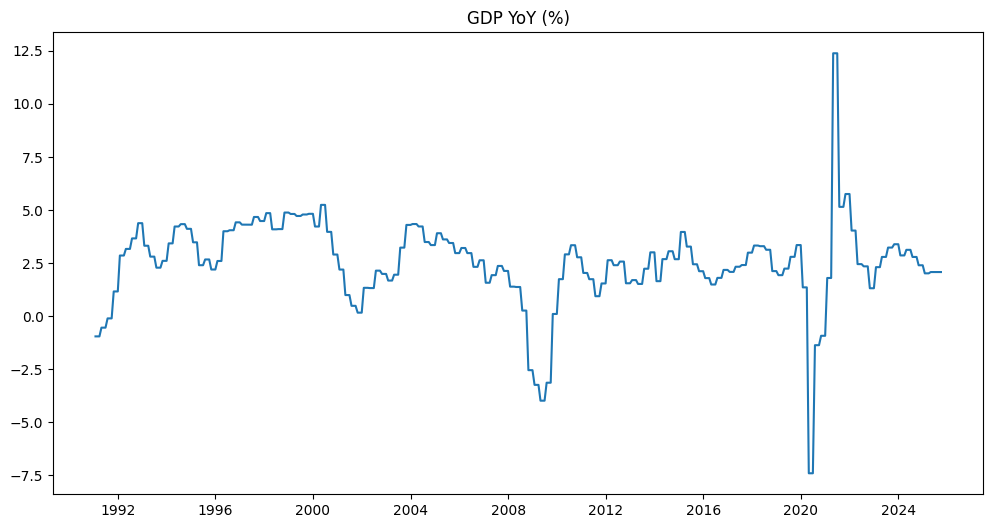

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['GDP_YoY'])
plt.title('GDP YoY (%)')
plt.show()

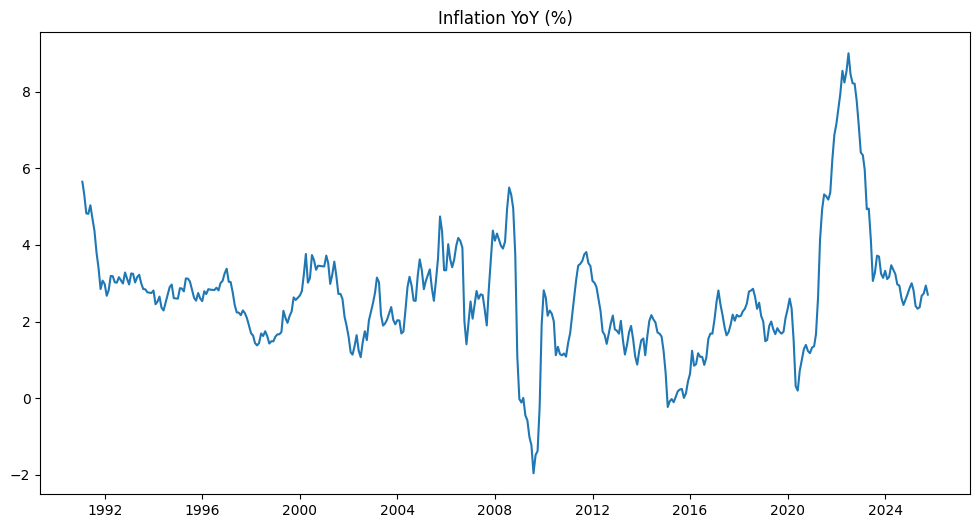

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Inflation_YoY'])
plt.title('Inflation YoY (%)')
plt.show()

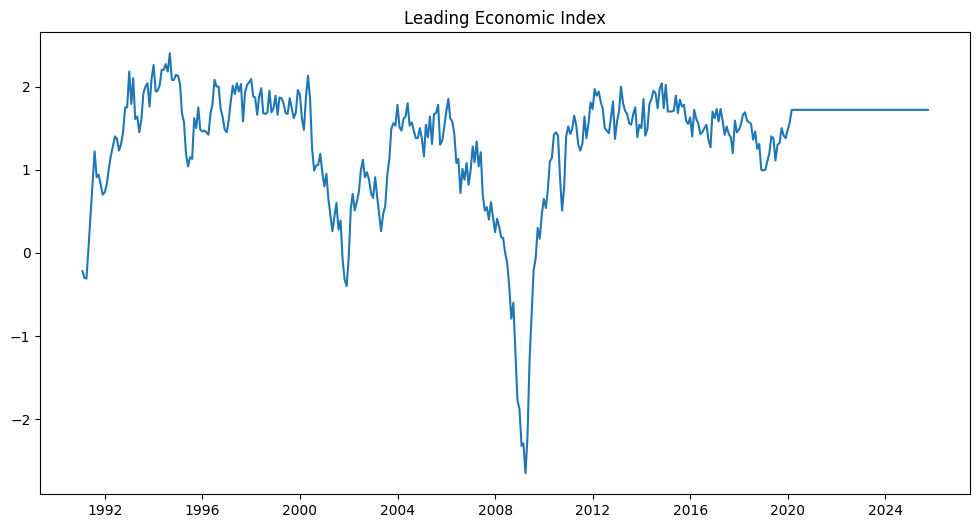

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['LEI'], label='LEI')
plt.title('Leading Economic Index')
plt.show()

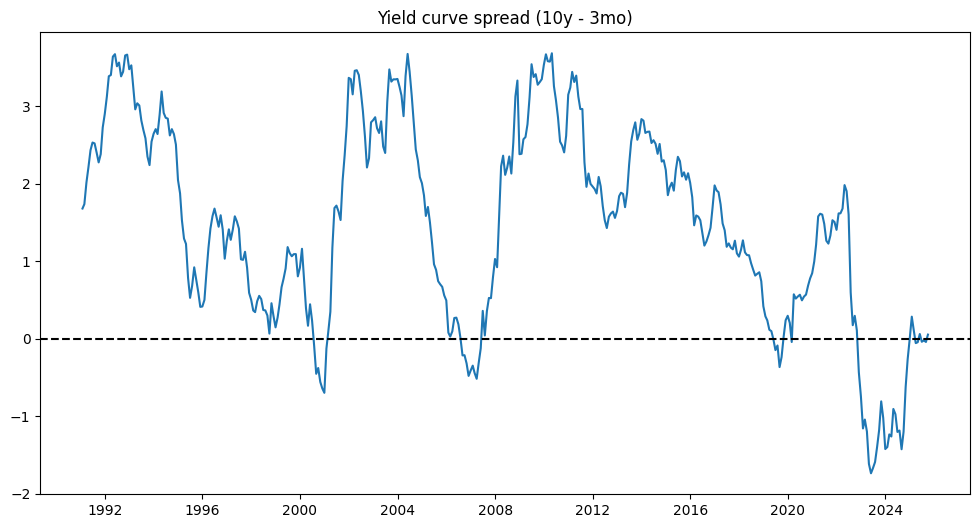

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['YC_Spread'], label='Yield curve (10y-3m)')
plt.axhline(0, color='k', linestyle='--')
plt.title('Yield curve spread (10y - 3mo)')
plt.show()

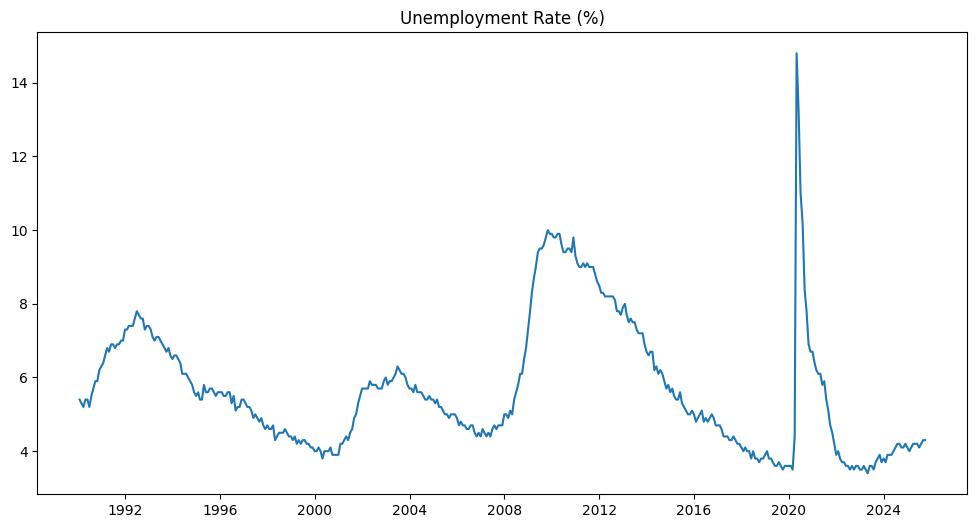

In [9]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['UNRATE'])
plt.title('Unemployment Rate (%)')
plt.show()

In [10]:
print('\nCorrelation matrix:')
print(data[['GDP_YoY','Inflation_YoY','UNRATE','FEDFUNDS','LEI']].corr())


Correlation matrix:
                GDP_YoY  Inflation_YoY    UNRATE  FEDFUNDS       LEI
GDP_YoY        1.000000       0.268350 -0.456145  0.247774  0.572351
Inflation_YoY  0.268350       1.000000 -0.343281  0.277081  0.123964
UNRATE        -0.456145      -0.343281  1.000000 -0.444591 -0.219506
FEDFUNDS       0.247774       0.277081 -0.444591  1.000000  0.035042
LEI            0.572351       0.123964 -0.219506  0.035042  1.000000


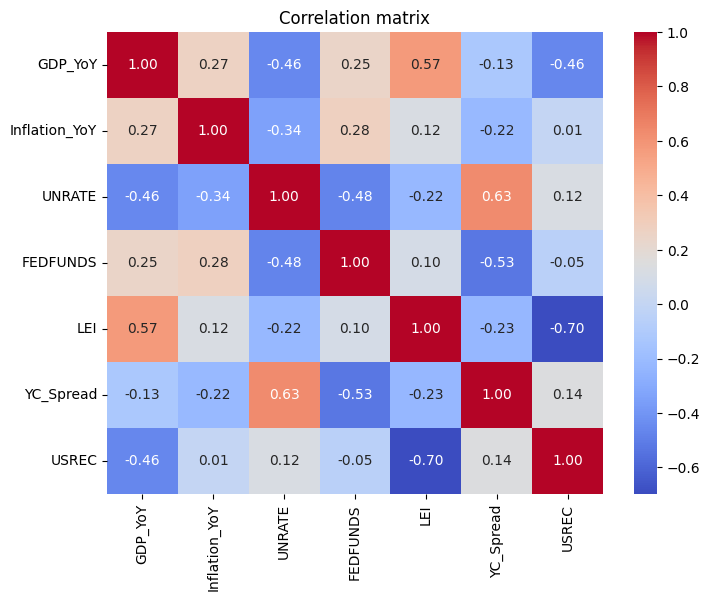

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

## **5. Stationarity checks (ADF test) and differencing decisions**
We'll run ADF and decide whether to difference certain series for VAR. We'll print p-values.

In [12]:
def adf_report(series, name):
    res = adfuller(series.dropna())
    print(f"ADF {name}: stat={res[0]:.3f}, p-value={res[1]:.3f}")

for col in ['GDP_YoY','Inflation_YoY','UNRATE','FEDFUNDS','LEI','YC_Spread']:
    adf_report(df[col], col)

ADF GDP_YoY: stat=-3.527, p-value=0.007
ADF Inflation_YoY: stat=-3.623, p-value=0.005
ADF UNRATE: stat=-3.003, p-value=0.035
ADF FEDFUNDS: stat=-3.113, p-value=0.026
ADF LEI: stat=-2.991, p-value=0.036
ADF YC_Spread: stat=-2.631, p-value=0.087


The Augmented Dickey-Fuller (ADF) test suggests that YC_Spread is non-stationary (p-value < 0.05). Fitting an ARIMA or VAR model to non-stationary data leads to spurious regressions and unreliable forecasts.

In [13]:
# Difference YC_Spread to remove non-stationarity
df['YC_Spread_diff'] = df['YC_Spread'].diff()

## **6. VAR model with automatic lag selection and rolling evaluation**
We will implement a rolling-window VAR evaluation function:
- training window: 36 months (3 years)
- test window (forecast horizon): 6 months
- step: advance by 6 months (non-overlapping test windows)

For each rolling window we fit VAR and record forecasts and RMSE per variable.

In [14]:
def rolling_var_forecast(df_vars, train_window=36, test_window=6, step=6, maxlags=12):
    dates = df_vars.index
    results = []
    start_idx = 0
    
    while True:
        train_start = start_idx
        train_end = train_start + train_window - 1
        test_start = train_end + 1
        test_end = test_start + test_window - 1
        if test_end >= len(dates):
            break

        train_idx = slice(train_start, train_end+1)
        test_idx = slice(test_start, test_end+1)
        train = df_vars.iloc[train_idx]
        test = df_vars.iloc[test_idx]

        # Select lag by BIC
        model = VAR(train)
        try:
            lag_order = model.select_order(maxlags).bic
            if lag_order <= 0:  # fallback
                lag_order = 2
        except:
            lag_order = 2

        # Fit VAR with optimal lag
        fitted = model.fit(lag_order)

        # Forecast
        fc = fitted.forecast(y=train.values[-lag_order:], steps=test_window)
        fc_df = pd.DataFrame(fc, index=test.index, columns=df_vars.columns)

        # Compute RMSE per variable
        rmses = {col: sqrt(mean_squared_error(test[col], fc_df[col])) for col in df_vars.columns}

        results.append({
            'train_start': dates[train_start],
            'train_end': dates[train_end],
            'test_start': dates[test_start],
            'test_end': dates[test_end],
            'lag': lag_order,
            'rmses': rmses,
            'forecast': fc_df,
            'actual': test
        })

        start_idx += step

    return results

In [15]:
# Select VAR variables: keep macro set (exclude USREC)
var_vars = df[['GDP_YoY','Inflation_YoY','UNRATE','FEDFUNDS','LEI','YC_Spread_diff']].dropna()
var_results = rolling_var_forecast(var_vars, train_window=72, test_window=6, step=6, maxlags=12)

print('Rolled windows:', len(var_results))

Rolled windows: 57


In [16]:
rmse_table = pd.DataFrame([r['rmses'] for r in var_results], index=[r['test_start'] for r in var_results])
print(rmse_table.describe().T)

                count      mean       std       min       25%       50%  \
GDP_YoY          57.0  1.505564  1.933956  0.169414  0.444949  0.671004   
Inflation_YoY    57.0  1.083920  0.985194  0.147507  0.455416  0.843555   
UNRATE           57.0  0.634790  1.181155  0.048276  0.124339  0.221954   
FEDFUNDS         57.0  0.470937  0.448188  0.008299  0.134662  0.358949   
LEI              57.0  0.389534  0.446885  0.003148  0.169318  0.258494   
YC_Spread_diff   57.0  0.248201  0.095918  0.082304  0.183524  0.229597   

                     75%       max  
GDP_YoY         1.715259  8.236843  
Inflation_YoY   1.200824  5.281982  
UNRATE          0.499942  7.174249  
FEDFUNDS        0.587977  2.027907  
LEI             0.456111  2.970389  
YC_Spread_diff  0.319471  0.519132  


<Figure size 1000x500 with 0 Axes>

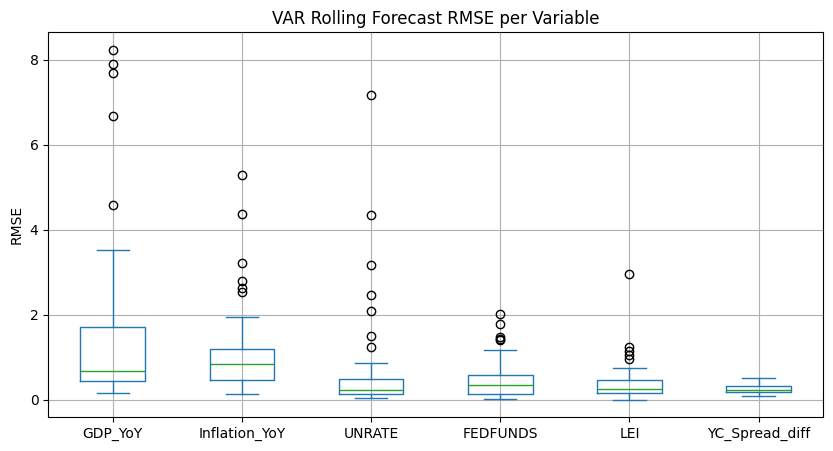

In [17]:
plt.figure(figsize=(10,5))
rmse_table.plot(kind='box', figsize=(10,5), grid=True)
plt.title('VAR Rolling Forecast RMSE per Variable')
plt.ylabel('RMSE')
plt.show()

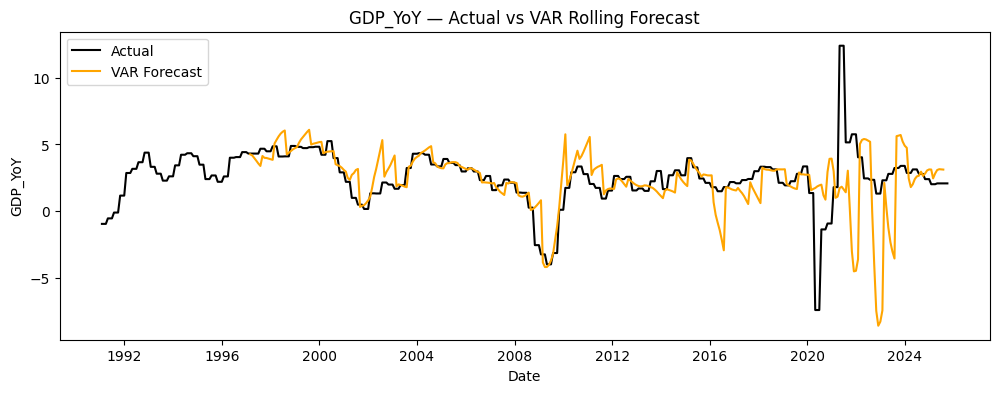

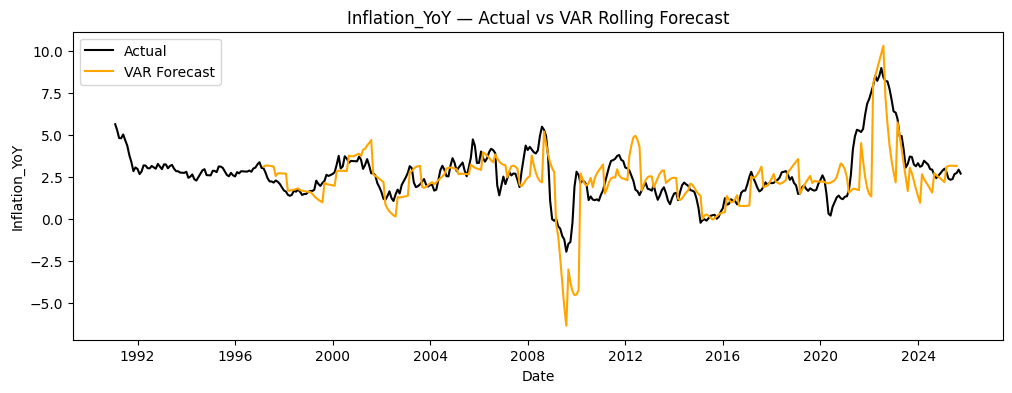

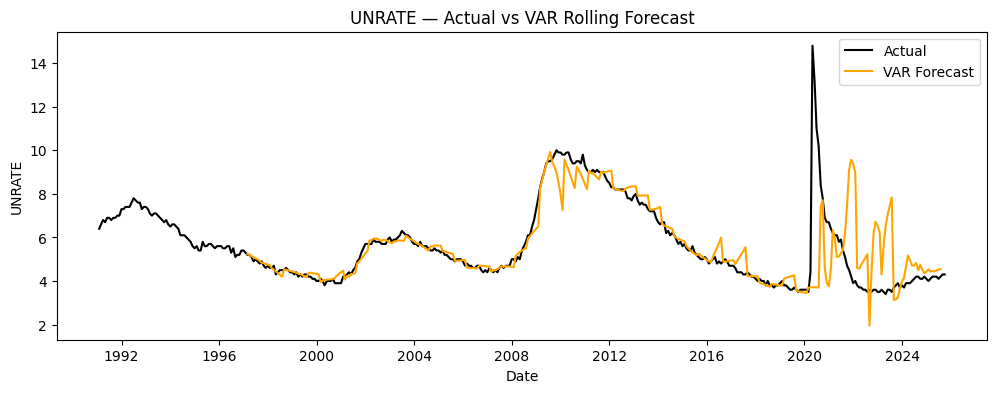

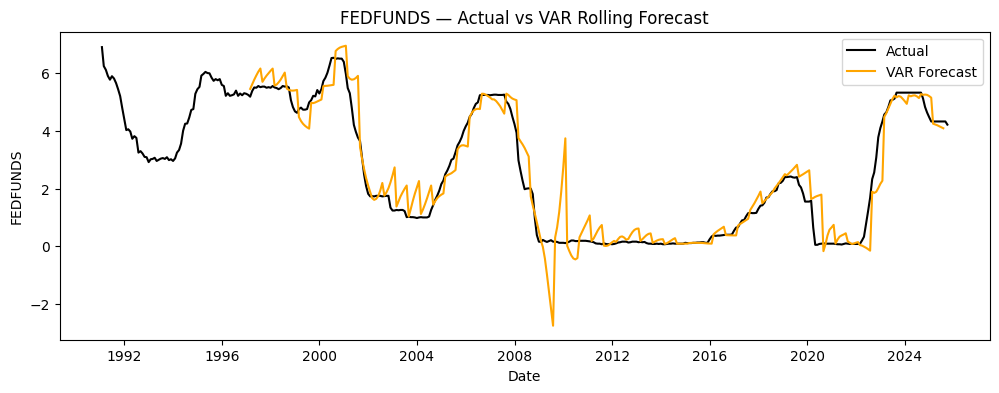

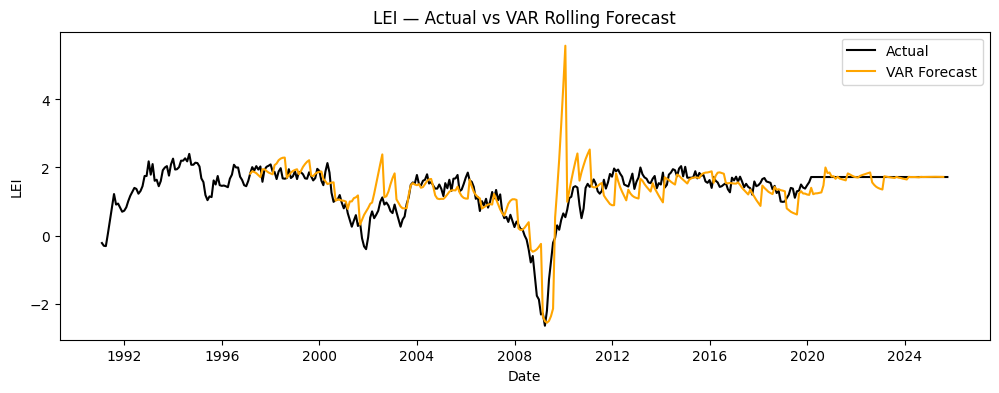

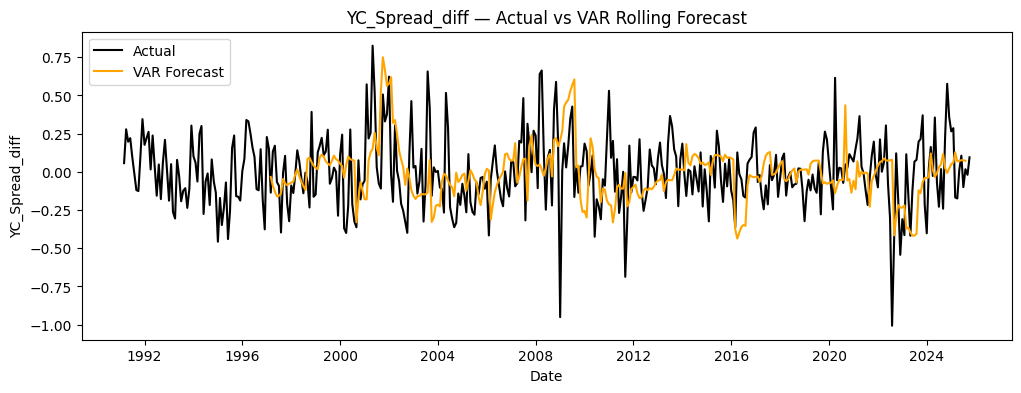

In [18]:
# Concatenate all rolling forecasts
all_forecasts = pd.concat([r['forecast'] for r in var_results])
all_actuals = pd.concat([r['actual'] for r in var_results])

# Plot each variable separately
for col in var_vars.columns:
    plt.figure(figsize=(12,4))
    # Full actual series
    plt.plot(df.index, df[col], label='Actual', color='black')
    # Overlay rolling forecasts
    plt.plot(all_forecasts.index, all_forecasts[col], label='VAR Forecast', color='orange')
    plt.title(f'{col} — Actual vs VAR Rolling Forecast')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.show()

## **7. Automated ARIMA selection (pmdarima) + rolling evaluation for Inflation**
We'll use pmdarima.auto_arima on the training window and forecast the test window; repeat in rolling fashion similar to VAR.

In [19]:
def rolling_arima_forecast(series, train_window=36, test_window=6, step=6, seasonal=False, m=12):
    dates = series.index
    results = []
    start_idx = 0
    while True:
        train_start = start_idx
        train_end = train_start + train_window - 1
        test_start = train_end + 1
        test_end = test_start + test_window - 1
        if test_end >= len(dates):
            break
        train = series.iloc[train_start:train_end+1]
        test = series.iloc[test_start:test_end+1]

        # auto_arima
        try:
            ar = pm.auto_arima(
                    train,
                    start_p=1, start_q=1,
                    max_p=5, max_q=5,
                    m=12,              # Set m=12 for monthly seasonality (S=12)
                    seasonal=True,
                    d=None,            # Let auto_arima determine differencing order (d)
                    D=1,               # Force seasonal differencing
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True
                )
            order = ar.order
            # Forecast
            fc = ar.predict(n_periods=len(test))
        except Exception as e:
            # fallback to ARIMA(1,0,1)
            ar = ARIMA(train, order=(1,0,1)).fit()
            fc = ar.predict(start=test.index[0], end=test.index[-1])

        rmse = sqrt(mean_squared_error(test, fc))
        results.append({'train_start':dates[train_start], 'train_end':dates[train_end], 'test_start':dates[test_start], 'test_end':dates[test_end], 'model':getattr(ar, 'order', None), 'rmse':rmse, 'forecast':pd.Series(fc, index=test.index), 'actual':test})

        start_idx += step
    return results

In [20]:
infl_results = rolling_arima_forecast(df['Inflation_YoY'], train_window=36, test_window=6, step=6, seasonal=False, m=12)

print('ARIMA rolling windows:', len(infl_results))
print('Inflation RMSE mean:', np.mean([r['rmse'] for r in infl_results]))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=25.502, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=20.883, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=26.669, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=22.842, Time=0.87 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=24.778, Time=1.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=20.404, Time=0.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=22.404, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=22.404, Time=0.16 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=24.404, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=20.503, Time=0.14 s

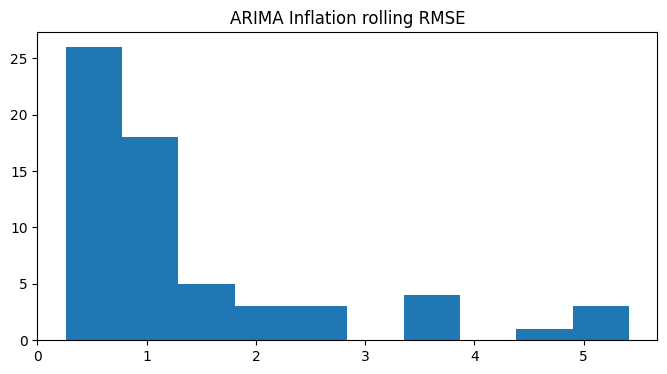

In [21]:
# Plot distribution
plt.figure(figsize=(8,4))
plt.hist([r['rmse'] for r in infl_results], bins=10)
plt.title('ARIMA Inflation rolling RMSE')
plt.show()

In [22]:
rmse_table = pd.DataFrame([r['rmse'] for r in infl_results],
                          index=[r['test_end'] for r in infl_results])
print(rmse_table.describe())  # mean, std, min, max RMSE

               0
count  63.000000
mean    1.415571
std     1.322898
min     0.257098
25%     0.529772
50%     0.946021
75%     1.587831
max     5.417521


In [23]:
for r in infl_results:
    print(f"{r['test_start'].date()} to {r['test_end'].date()}: order={r['model']}, RMSE={r['rmse']:.3f}")

1994-01-31 to 1994-06-30: order=(0, 1, 0), RMSE=1.153
1994-07-31 to 1994-12-31: order=(1, 0, 0), RMSE=0.356
1995-01-31 to 1995-06-30: order=(0, 0, 1), RMSE=0.473
1995-07-31 to 1995-12-31: order=(0, 1, 0), RMSE=0.343
1996-01-31 to 1996-06-30: order=(0, 1, 2), RMSE=0.502
1996-07-31 to 1996-12-31: order=(1, 0, 0), RMSE=0.452
1997-01-31 to 1997-06-30: order=(2, 0, 0), RMSE=0.758
1997-07-31 to 1997-12-31: order=(1, 0, 0), RMSE=0.935
1998-01-31 to 1998-06-30: order=(0, 1, 0), RMSE=0.715
1998-07-31 to 1998-12-31: order=(0, 1, 0), RMSE=0.257
1999-01-31 to 1999-06-30: order=(1, 0, 0), RMSE=0.946
1999-07-31 to 1999-12-31: order=(0, 1, 0), RMSE=0.650
2000-01-31 to 2000-06-30: order=(0, 1, 0), RMSE=0.453
2000-07-31 to 2000-12-31: order=(0, 1, 0), RMSE=1.069
2001-01-31 to 2001-06-30: order=(0, 1, 0), RMSE=0.559
2001-07-31 to 2001-12-31: order=(0, 1, 0), RMSE=1.429
2002-01-31 to 2002-06-30: order=(0, 1, 1), RMSE=0.463
2002-07-31 to 2002-12-31: order=(0, 1, 0), RMSE=2.425
2003-01-31 to 2003-06-30: or

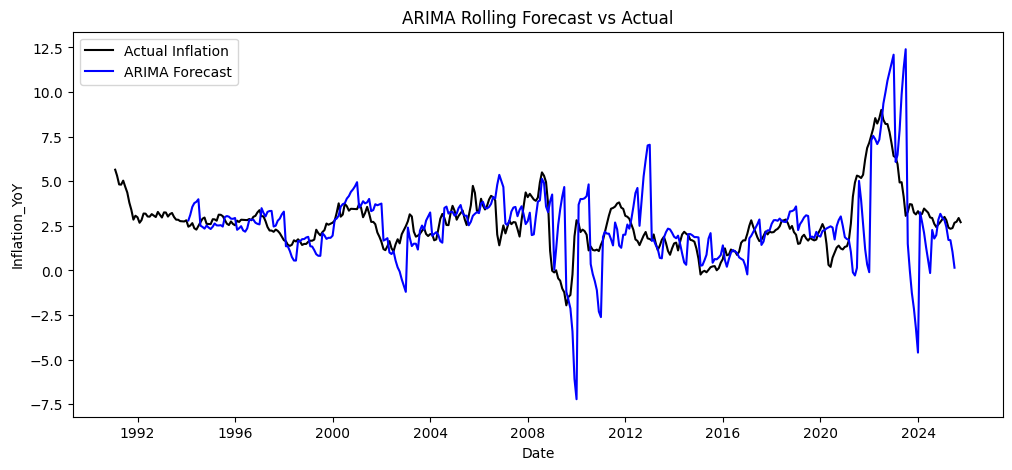

In [24]:
# Concatenate forecasts
all_fc = pd.concat([r['forecast'] for r in infl_results])
all_actual = pd.concat([r['actual'] for r in infl_results])

plt.figure(figsize=(12,5))
plt.plot(df['Inflation_YoY'].index, df['Inflation_YoY'], label='Actual Inflation', color='black')
plt.plot(all_fc.index, all_fc, label='ARIMA Forecast', color='blue')
plt.title('ARIMA Rolling Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(df['Inflation_YoY'].name)
plt.legend()
plt.show()

## **8. Recession classification (USREC) using LEI and yield curve**
We'll build a logistic regression classifier to predict monthly recession indicator (USREC) using:
- LEI (current level or change)
- YC_Spread (current)
- Optionally lagged values

We will:
- Create features: LEI change (12-month %), YC_Spread, and their lags (1-6 months)
- Train-test split by time (first 80% train, last 20% test)
- Evaluate using ROC AUC and plot ROC

### 8.1. Feature Engineering

In [25]:
# Create Momentum and Rate-of-Change Features
# The change in unemployment (6-month difference) is a powerful leading indicator (Sahm Rule concept)
df['UNRATE_Change_6M'] = df['UNRATE'].diff(6) 
# 12-month change in the Fed Funds Rate signals monetary policy shifts
df['FEDFUNDS_Change_12M'] = df['FEDFUNDS'].diff(12) 
# Momentum in the LEI (YoY percentage change)
df['LEI_YoY'] = df['LEI'].pct_change(12) * 100
# Only YC_Spread was non-stationary, so we only difference it.
df['YC_Spread_Diff'] = df['YC_Spread'].diff(1)

# Drop NaNs created by differencing (up to 12 months)
clf_df_temp = df.dropna().copy()

### 8.2. Lagging and Target Creation

In [26]:
LAG = 12 # Predict the target 12 months (t+12) ahead

# Define the set of features to be lagged
original_features = ['GDP_YoY', 'Inflation_YoY', 'UNRATE', 'FEDFUNDS', 'LEI', 
                     'YC_Spread', 'UNRATE_Change_6M', 'FEDFUNDS_Change_12M', 
                     'LEI_YoY', 'YC_Spread_Diff'] 
feature_lags = [1, 3, 6, 12]
X_cols = []

for col in original_features:
    for lag in feature_lags:
        new_col = f'{col}_L{lag}'
        clf_df_temp[new_col] = clf_df_temp[col].shift(lag)
        X_cols.append(new_col)

# Create Forward-Looking Target (Y)
# Target variable is recession 12 months in the future
clf_df_temp['USREC_Target'] = clf_df_temp['USREC'].shift(-LAG)

# Finalize the X and y dataframes by dropping remaining NaNs
clf_df = clf_df_temp.dropna().copy()

X = clf_df[X_cols]
y = clf_df['USREC_Target']

# Check data balance again
print("X and y dataframes created successfully.")
print(f"Target Balance (1.0 = Recession): \n{y.value_counts(normalize=True)}")

X and y dataframes created successfully.
Target Balance (1.0 = Recession): 
USREC_Target
0.0    0.926509
1.0    0.073491
Name: proportion, dtype: float64


### 8.3.a. Walk-forward Validation (Logistic Regression)
Performs walk-forward validation for recession classification using Logistic Regression.

Includes data cleaning, scaling, class weighting, and inverted AUC check.

In [27]:
def run_walk_forward_validation_logreg(X: pd.DataFrame, y: pd.Series, initial_train_years: int = 10):
    initial_train_size = int(initial_train_years * 12)
    test_size = 12

    auc_scores = []
    
    print(f"Starting Walk-Forward Validation (Initial Train: {initial_train_years} years, Test Step: {test_size} months)")

    for start_idx in range(initial_train_size, len(X), test_size):
        
        train_end = start_idx
        test_end = min(start_idx + test_size, len(X))
        
        if test_end <= train_end:
            break
            
        X_train, X_test = X.iloc[:train_end], X.iloc[train_end:test_end]
        y_train, y_test = y.iloc[:train_end], y.iloc[train_end:test_end]
        
        # Replace inf with NaN
        X_train_cleaned = X_train.replace([np.inf, -np.inf], np.nan)
        X_test_cleaned = X_test.replace([np.inf, -np.inf], np.nan)
        
        # Impute NaNs using the mean of the training set (prevents look-ahead bias)
        imputer_means = X_train_cleaned.mean()
        X_train_imputed = X_train_cleaned.fillna(imputer_means)
        X_test_imputed = X_test_cleaned.fillna(imputer_means)
        
        # Data Scaling: Fit the scaler only on the training data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Train the Model (class_weight='balanced' handles imbalanced data)
        logreg_model = LogisticRegression(
            solver='liblinear',
            max_iter=1000,
            class_weight='balanced', 
            random_state=42
        )
        
        logreg_model.fit(X_train_scaled, y_train)
        
        # Predict Probabilities
        y_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]
        
        # Evaluate and Store AUC
        if len(np.unique(y_test)) > 1:
            # Check for inverted prediction (1.0 - y_prob)
            auc_normal = roc_auc_score(y_test, y_prob)
            auc_inverted = roc_auc_score(y_test, 1.0 - y_prob)
            
            if auc_inverted > auc_normal:
                auc = auc_inverted
                print(f"Test Period: {y_test.index[0].strftime('%Y-%m')} to {y_test.index[-1].strftime('%Y-%m')} | AUC: {auc:.4f} (Inverted)")
            else:
                auc = auc_normal
                print(f"Test Period: {y_test.index[0].strftime('%Y-%m')} to {y_test.index[-1].strftime('%Y-%m')} | AUC: {auc:.4f} (Normal)")
                
            auc_scores.append(auc)
                
    return auc_scores

### 8.3.b. Walk-forward Validation (XGBoost)
Performs walk-forward validation for recession classification using XGBoost.

In [28]:
def run_walk_forward_validation_xgb(X: pd.DataFrame, y: pd.Series, initial_train_years: int = 10):

    initial_train_size = int(initial_train_years * 12)
    test_size = 12

    # Calculate scale_pos_weight for XGBoost
    neg_count = y.value_counts()[0]
    pos_count = y.value_counts()[1]
    scale_pos_weight_value = neg_count / pos_count
    
    auc_scores = []
    
    print(f"Starting XGBoost Walk-Forward Validation (Initial Train: {initial_train_years} years, Test Step: {test_size} months)")

    for start_idx in range(initial_train_size, len(X), test_size):
        
        train_end = start_idx
        test_end = min(start_idx + test_size, len(X))
        
        if test_end <= train_end:
            break
            
        X_train, X_test = X.iloc[:train_end], X.iloc[train_end:test_end]
        y_train, y_test = y.iloc[:train_end], y.iloc[train_end:test_end]
        
        # Replace inf with NaN
        X_train_cleaned = X_train.replace([np.inf, -np.inf], np.nan)
        X_test_cleaned = X_test.replace([np.inf, -np.inf], np.nan)

        # Impute NaNs using the mean of the training set (prevents look-ahead bias)
        imputer_means = X_train_cleaned.mean()
        X_train_imputed = X_train_cleaned.fillna(imputer_means)
        X_test_imputed = X_test_cleaned.fillna(imputer_means)
        
        # Data Scaling (required for XGBoost for consistency)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_test_scaled = scaler.transform(X_test_imputed)

        # Train the Model (XGBoost)
        xgb_model = XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight_value, # Use calculated weight for imbalance
            n_estimators=100,
            max_depth=5,
            random_state=42
        )
        
        xgb_model.fit(X_train_scaled, y_train)
        
        # Predict Probabilities
        y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
        
        # Evaluate and Store AUC
        if len(np.unique(y_test)) > 1:
            # Check for inverted prediction
            auc_normal = roc_auc_score(y_test, y_prob)
            auc_inverted = roc_auc_score(y_test, 1.0 - y_prob)
            
            if auc_inverted > auc_normal:
                auc = auc_inverted
                print(f"Test Period: {y_test.index[0].strftime('%Y-%m')} to {y_test.index[-1].strftime('%Y-%m')} | AUC: {auc:.4f} (Inverted)")
            else:
                auc = auc_normal
                print(f"Test Period: {y_test.index[0].strftime('%Y-%m')} to {y_test.index[-1].strftime('%Y-%m')} | AUC: {auc:.4f} (Normal)")
                
            auc_scores.append(auc)
        
    return auc_scores

### 8.4. Walk-forward Validation Results

In [29]:
print("Running Logistic Regression Walk-Forward Validation...")
logreg_auc_scores = run_walk_forward_validation_logreg(X, y, initial_train_years=10)

print("Running XGBoost Walk-Forward Validation...")
xgb_auc_scores = run_walk_forward_validation_xgb(X, y, initial_train_years=10)

print(f"\nAverage LogReg ROC AUC: {np.mean(logreg_auc_scores):.4f}")
print(f"Average XGBoost ROC AUC: {np.mean(xgb_auc_scores):.4f}")

Running Logistic Regression Walk-Forward Validation...
Starting Walk-Forward Validation (Initial Train: 10 years, Test Step: 12 months)
Test Period: 2008-01 to 2008-12 | AUC: 0.8056 (Normal)
Test Period: 2019-01 to 2019-12 | AUC: 0.9000 (Inverted)
Running XGBoost Walk-Forward Validation...
Starting XGBoost Walk-Forward Validation (Initial Train: 10 years, Test Step: 12 months)
Test Period: 2008-01 to 2008-12 | AUC: 0.7778 (Normal)
Test Period: 2019-01 to 2019-12 | AUC: 1.0000 (Normal)

Average LogReg ROC AUC: 0.8528
Average XGBoost ROC AUC: 0.8889


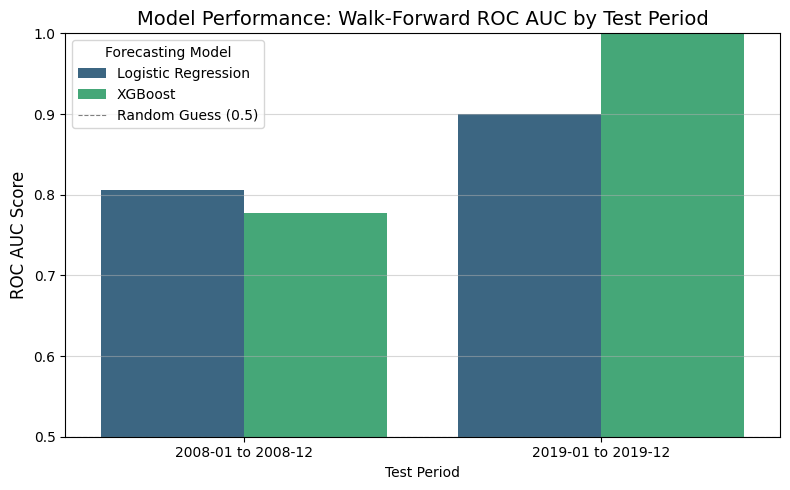

In [30]:
periods = ['2008-01 to 2008-12', '2019-01 to 2019-12']

plot_data = pd.DataFrame({
    'Test Period': periods,
    'Logistic Regression': logreg_auc_scores,
    'XGBoost': xgb_auc_scores
})
plot_melted = plot_data.melt(id_vars='Test Period', var_name='Model', value_name='ROC AUC')

plt.figure(figsize=(8, 5))
sns.barplot(x='Test Period', y='ROC AUC', hue='Model', data=plot_melted, palette='viridis')
plt.title('Model Performance: Walk-Forward ROC AUC by Test Period', fontsize=14)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.ylim(0.5, 1.0)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.8, label='Random Guess (0.5)')
plt.legend(title='Forecasting Model')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

### 8.5. Final Model Fit and Coefficient Extraction

In [31]:
# Clean and impute the full dataset
X_cleaned = X.replace([np.inf, -np.inf], np.nan)
imputer_means = X_cleaned.mean()
X_imputed = X_cleaned.fillna(imputer_means)

# Scale the full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Fit the final LogReg Model (same parameters as in validation)
final_logreg_model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
final_logreg_model.fit(X_scaled, y.values.ravel())

# Extract and sort coefficients
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': final_logreg_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

### 8.6. Visualization

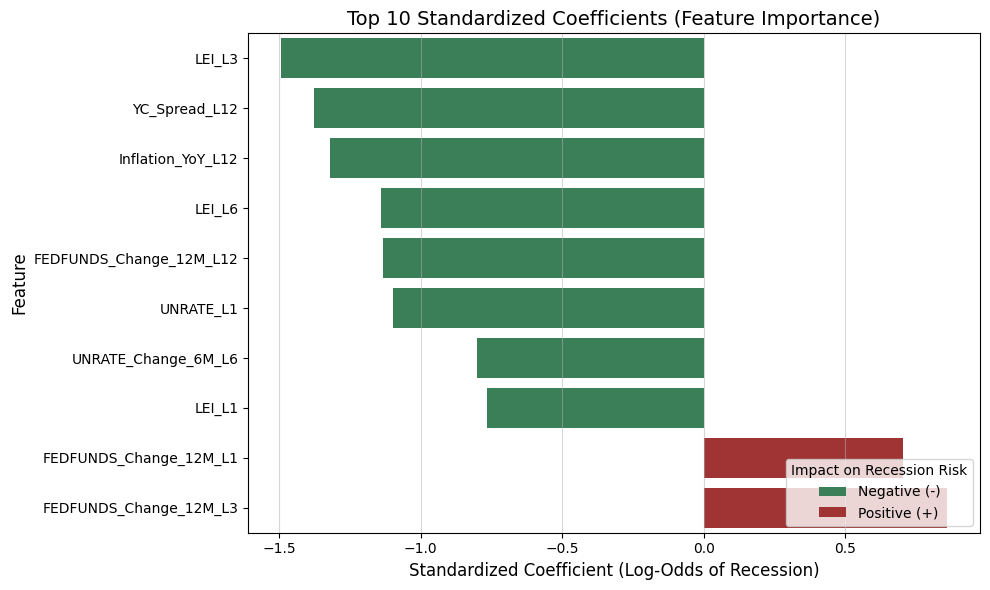

In [32]:
top_n = 10
top_coefficients = coefficients_df.head(top_n).sort_values('Coefficient', ascending=True)

# Create a column for sign for color coding
top_coefficients['Sign'] = np.where(top_coefficients['Coefficient'] > 0, 'Positive (+)', 'Negative (-)')

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=top_coefficients, 
    hue='Sign', 
    dodge=False, 
    palette={'Positive (+)': 'firebrick', 'Negative (-)': 'seagreen'}
)
plt.title(f'Top {top_n} Standardized Coefficients (Feature Importance)', fontsize=14)
plt.xlabel('Standardized Coefficient (Log-Odds of Recession)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Impact on Recession Risk', loc='lower right')
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

## **9. SHAP Analysis for Logistic Regression**

### 9.1. Initializing the Explainer and Running Analysis

In [33]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nStarting SHAP analysis...")

# Initialize the Explainer
# For linear models like Logistic Regression, the LinearExplainer is computationally efficient.
# Note: SHAP explains the model's output. For LogReg, this output is the log-odds of a recession.
explainer = shap.LinearExplainer(
    final_logreg_model, 
    X_scaled_df, 
    feature_perturbation="interventional" # Safe assumption for standardized linear features
)

# Calculate SHAP values for all observations
shap_values = explainer.shap_values(X_scaled_df)


Starting SHAP analysis...


### 9.2. Visualization

Generating SHAP Summary Bar Plot (Global Importance)...


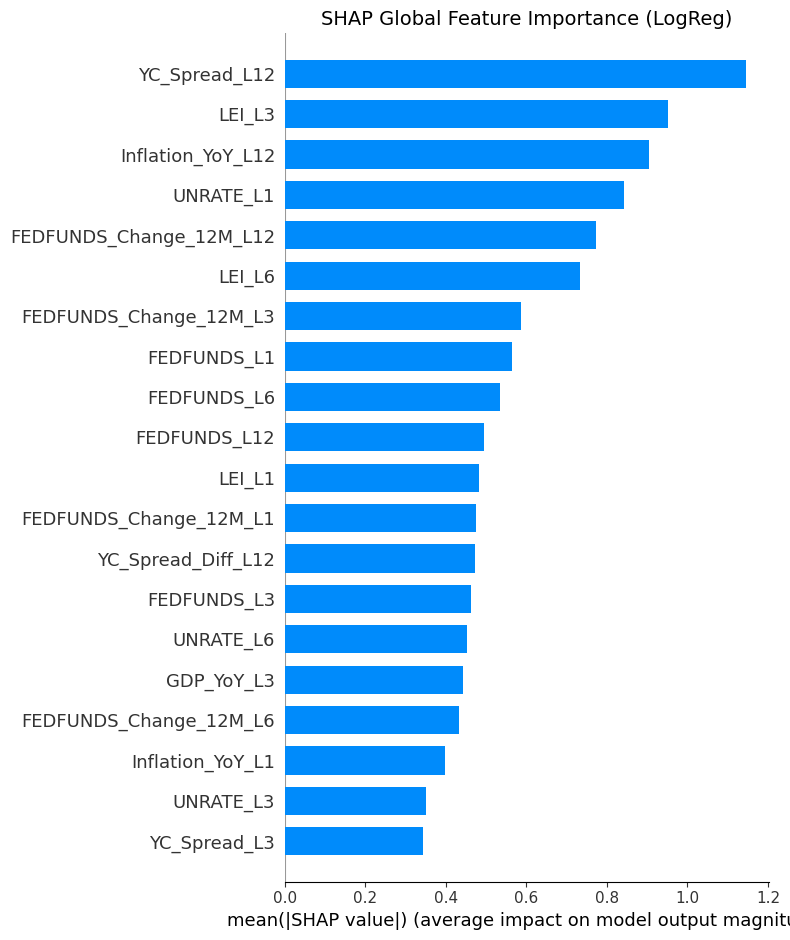

In [34]:
# A. Global Bar Plot (Mean Absolute SHAP Value)
print("Generating SHAP Summary Bar Plot (Global Importance)...")
shap.summary_plot(
    shap_values, 
    X_scaled_df, 
    plot_type="bar", 
    show=False # Use plt.show() outside of the function
)
plt.title("SHAP Global Feature Importance (LogReg)", fontsize=14)
plt.tight_layout()
plt.show()

Generating SHAP Summary Dot Plot (Magnitude and Direction)...


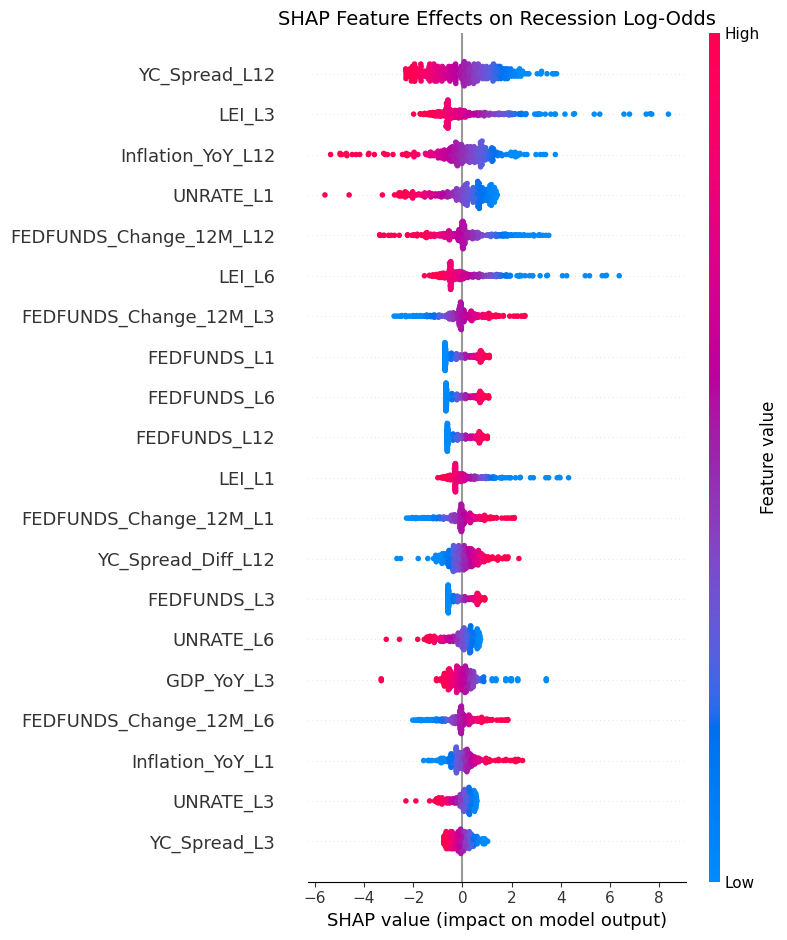

In [35]:
# B. Summary Dot Plot (Magnitude and Direction)
print("Generating SHAP Summary Dot Plot (Magnitude and Direction)...")
shap.summary_plot(
    shap_values, 
    X_scaled_df,
    show=False
)
plt.title("SHAP Feature Effects on Recession Log-Odds", fontsize=14)
plt.tight_layout()
plt.show()


Generating SHAP Waterfall Plot for the highest risk month: 2007-12


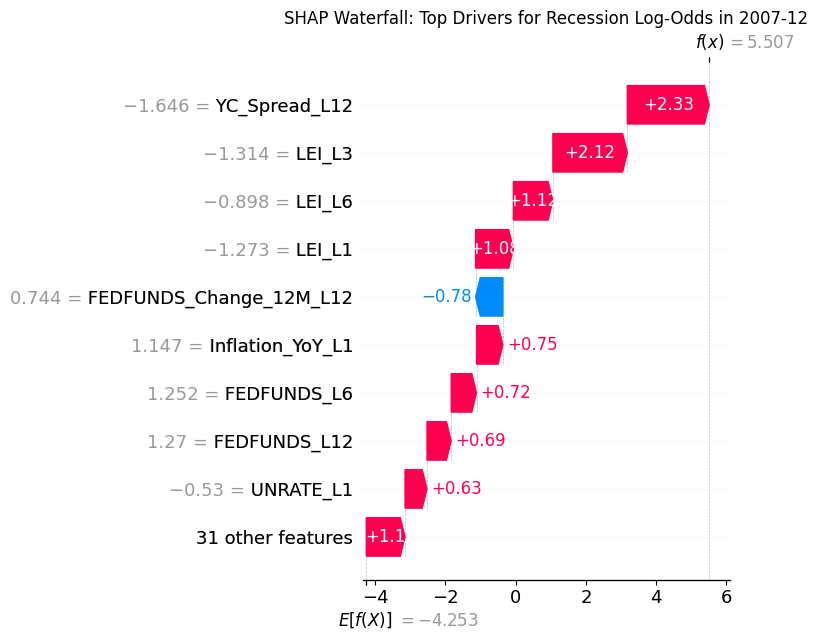

In [36]:
# C. Individual Waterfall Plot (Example of a high-risk prediction)
# Find the observation with the highest predicted probability of recession (highest log-odds)
high_risk_index = np.argmax(final_logreg_model.predict_log_proba(X_scaled)[:, 1])

print(f"\nGenerating SHAP Waterfall Plot for the highest risk month: {X_imputed.index[high_risk_index].strftime('%Y-%m')}")
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[high_risk_index], 
        base_values=explainer.expected_value, 
        data=X_scaled_df.iloc[high_risk_index].values, 
        feature_names=X_scaled_df.columns.tolist()
    ), 
    max_display=10, 
    show=False
)
plt.title(f"SHAP Waterfall: Top Drivers for Recession Log-Odds in {X_imputed.index[high_risk_index].strftime('%Y-%m')}", fontsize=12)
plt.tight_layout()
plt.show()

## **9. Dashboard-style summary plots**
- Show recent actual vs VAR forecast for key variables (take last rolling window)
- Plot LEI and predicted recession probability over time for test period

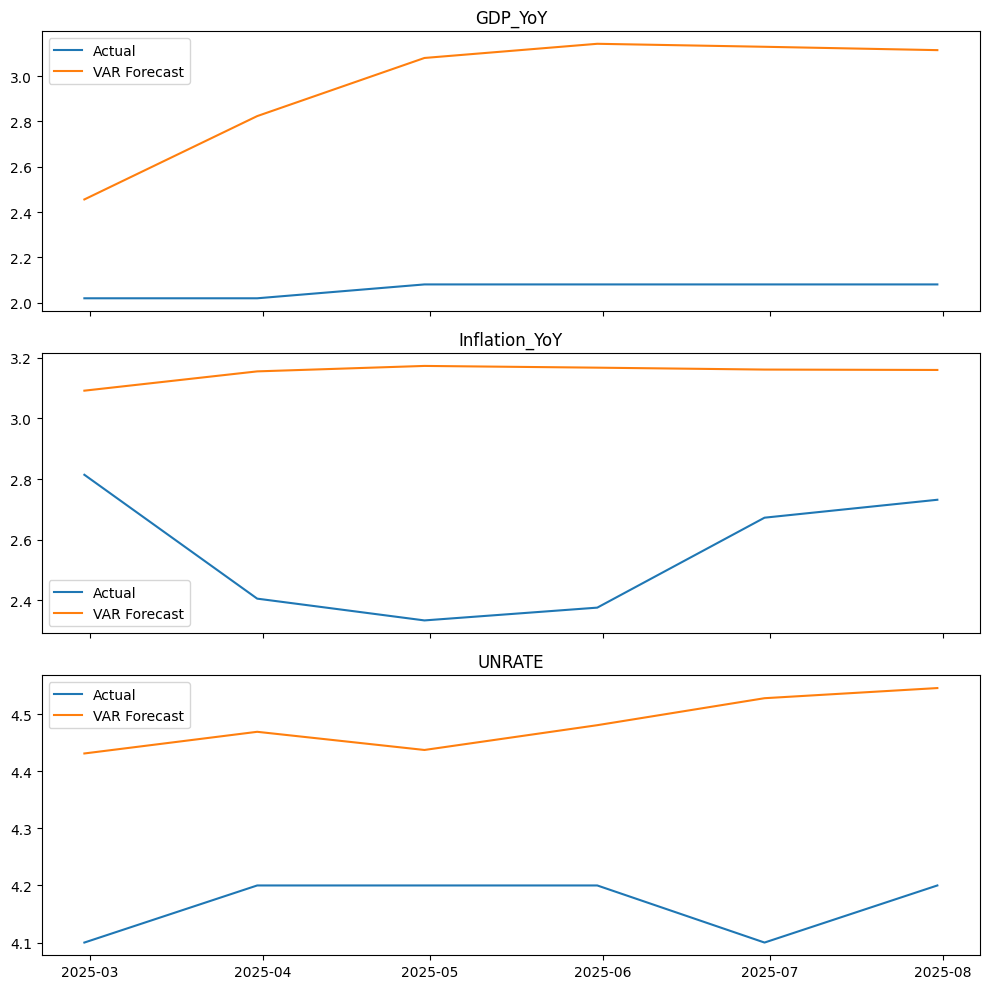

In [37]:
# Last VAR window plot for key series
last = var_results[-1]
fig, axes = plt.subplots(3,1,figsize=(10,10), sharex=True)
for i, col in enumerate(['GDP_YoY','Inflation_YoY','UNRATE']):
    axes[i].plot(last['actual'].index, last['actual'][col], label='Actual')
    axes[i].plot(last['forecast'].index, last['forecast'][col], label='VAR Forecast')
    axes[i].legend()
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

## **10. Predict Recession Probabilities Over Time**

### 10.1. Generate Final Probabilities

In [38]:
# Predict the probability of recession (class 1)
recession_probs = final_logreg_model.predict_proba(X_scaled)[:, 1]

# Create a master DataFrame for plotting
forecast_df = pd.DataFrame({
    'Recession_Prob': recession_probs,
    'USREC_Target': y,
    'YC_Spread': X_imputed['YC_Spread_L1'] 
}, index=X_imputed.index).dropna()

### 10.2. Corrected Recession Shading Logic

In [39]:
# Identify start and end points of contiguous recession periods
df_temp = forecast_df.reset_index().rename(columns={'index': 'Date'})
df_temp['Group'] = (df_temp['USREC_Target'] != df_temp['USREC_Target'].shift(1)).cumsum()
recession_blocks = df_temp[df_temp['USREC_Target'] == 1.0].groupby('Group')['Date'].agg(['min', 'max'])

### 10.3. Final Visualization: Time-Series Probabilities

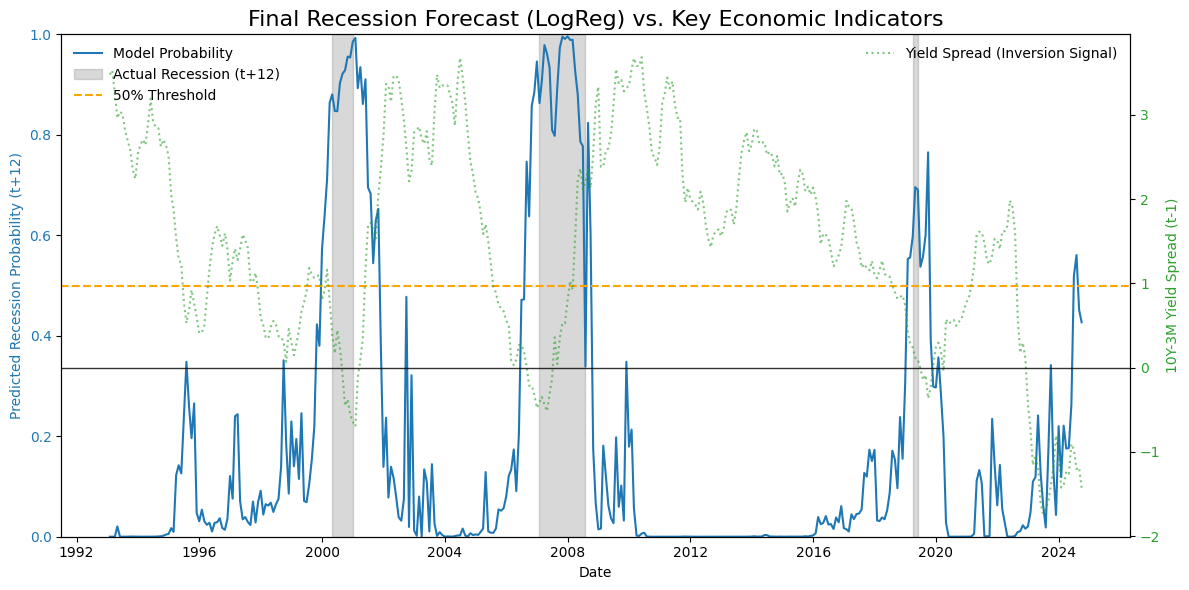

In [40]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 1: Recession Probability (Primary Y-axis)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Recession Probability (t+12)', color=color)
ax1.plot(forecast_df.index, forecast_df['Recession_Prob'], color=color, label='Model Probability')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.0) # Probability scale

legend_shade = True
for _, row in recession_blocks.iterrows():
    ax1.axvspan(
        row['min'], 
        row['max'] + pd.DateOffset(months=1), # Add 1 month to ensure the final month is fully shaded
        color='gray', 
        alpha=0.3, 
        label='Actual Recession (t+12)' if legend_shade else ""
    )
    legend_shade = False

ax1.axhline(0.5, color='orange', linestyle='--', linewidth=1.5, label='50% Threshold')
ax1.legend(loc='upper left', frameon=False)

# Plot 2: Yield Curve Spread (Secondary Y-axis)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('10Y-3M Yield Spread (t-1)', color=color)
ax2.plot(forecast_df.index, forecast_df['YC_Spread'], color=color, linestyle=':', alpha=0.6, label='Yield Spread (Inversion Signal)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.8) # Zero line for Yield Curve inversion

ax2.legend(loc='upper right', frameon=False)
plt.title('Final Recession Forecast (LogReg) vs. Key Economic Indicators', fontsize=16)
plt.tight_layout()
plt.show()